### Lab #3 - Global Trajectory Planning using Potential Field Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math

# =============================================================================
### POTENTIAL FIELD PLANNER CLASS
# =============================================================================


In [2]:
class PotentialFieldPlanner:
    """
    A class for path planning using the potential field method with RRT* fallback.
    """
    
    def __init__(self, workspace_size=(10, 10), resolution=0.1):
        self.workspace_size = workspace_size
        self.resolution = resolution
        
        # Create coordinate grid
        self.x_range = np.arange(0, workspace_size[0] + resolution, resolution)
        self.y_range = np.arange(0, workspace_size[1] + resolution, resolution)
        self.X, self.Y = np.meshgrid(self.x_range, self.y_range)
        
        # Initialize potential field
        self.potential_field = np.zeros_like(self.X)
        
        # Optimized parameters
        self.attractive_coeff = 2.0
        self.repulsive_coeff = 8.0
        self.influence_distance = 1.8
        
        # Store components
        self.start = None
        self.goal = None
        self.obstacles = []
        self.path = []
        
        print(f"Planner initialized with workspace: {workspace_size}")
        print(f"Grid resolution: {resolution}")
        print(f"Parameters - attract: {self.attractive_coeff}, repulse: {self.repulsive_coeff}")
        
    def add_obstacle(self, center, radius):
        self.obstacles.append({'center': center, 'radius': radius})
        print(f"Added obstacle: center=({center[0]:.1f}, {center[1]:.1f}), radius={radius:.1f}")
    
    def set_start_goal(self, start, goal):
        self.start = start
        self.goal = goal
        print(f"Start position: ({start[0]:.1f}, {start[1]:.1f})")
        print(f"Goal position: ({goal[0]:.1f}, {goal[1]:.1f})")
    
    def calculate_attractive_potential(self, point):
        if self.goal is None:
            return 0
        distance = math.sqrt((point[0] - self.goal[0])**2 + (point[1] - self.goal[1])**2)
        return 0.5 * self.attractive_coeff * distance**2
    
    def calculate_repulsive_potential(self, point):
        total_repulsive = 0
        for obstacle in self.obstacles:
            distance_to_center = math.sqrt(
                (point[0] - obstacle['center'][0])**2 + 
                (point[1] - obstacle['center'][1])**2
            )
            distance_to_edge = distance_to_center - obstacle['radius']
            
            if distance_to_edge <= self.influence_distance and distance_to_edge > 0:
                repulsive_potential = 0.5 * self.repulsive_coeff * (
                    (1.0 / distance_to_edge) - (1.0 / self.influence_distance)
                )**2
                total_repulsive += repulsive_potential
            elif distance_to_edge <= 0:
                total_repulsive += 1000
        return total_repulsive
    
    def build_potential_field(self):
        print("Building potential field...")
        for i, y in enumerate(self.y_range):
            for j, x in enumerate(self.x_range):
                point = (x, y)
                attractive = self.calculate_attractive_potential(point)
                repulsive = self.calculate_repulsive_potential(point)
                total_potential = attractive + repulsive
                # Clamp values for better visualization
                self.potential_field[i, j] = min(total_potential, 30.0)
        
        print("Potential field construction completed!")
        print(f"Min potential: {np.min(self.potential_field):.3f}")
        print(f"Max potential: {np.max(self.potential_field):.3f}")
        print(f"Mean potential: {np.mean(self.potential_field):.3f}")
    
    def calculate_gradient(self, point):
        h = 0.01
        
        # Attractive gradient
        if self.goal is not None:
            attr_grad_x = self.attractive_coeff * (point[0] - self.goal[0])
            attr_grad_y = self.attractive_coeff * (point[1] - self.goal[1])
        else:
            attr_grad_x = attr_grad_y = 0
        
        # Repulsive gradient
        rep_grad_x = rep_grad_y = 0
        for obstacle in self.obstacles:
            distance_to_center = math.sqrt(
                (point[0] - obstacle['center'][0])**2 + 
                (point[1] - obstacle['center'][1])**2
            )
            distance_to_edge = distance_to_center - obstacle['radius']
            
            if distance_to_edge <= self.influence_distance and distance_to_edge > 0:
                # Direction from obstacle center to point
                if distance_to_center > 0:
                    dir_x = (point[0] - obstacle['center'][0]) / distance_to_center
                    dir_y = (point[1] - obstacle['center'][1]) / distance_to_center
                    
                    magnitude = self.repulsive_coeff * (
                        (1.0 / distance_to_edge) - (1.0 / self.influence_distance)
                    ) * (1.0 / distance_to_edge**2)
                    
                    rep_grad_x += magnitude * dir_x
                    rep_grad_y += magnitude * dir_y
        
        return (attr_grad_x + rep_grad_x, attr_grad_y + rep_grad_y)
    
    def plan_path_potential_field(self, step_size=0.1, max_iterations=1000):
        if self.start is None or self.goal is None:
            return False
        
        current_pos = list(self.start)
        self.path = [tuple(current_pos)]
        tolerance = 0.3
        
        for iteration in range(max_iterations):
            distance_to_goal = math.sqrt(
                (current_pos[0] - self.goal[0])**2 + 
                (current_pos[1] - self.goal[1])**2
            )
            
            if distance_to_goal < tolerance:
                print(f"Goal reached in {iteration} iterations!")
                return True
            
            grad_x, grad_y = self.calculate_gradient(current_pos)
            grad_magnitude = math.sqrt(grad_x**2 + grad_y**2)
            
            if grad_magnitude < 1e-6:
                break
            
            direction_x = -grad_x / grad_magnitude
            direction_y = -grad_y / grad_magnitude
            
            new_x = current_pos[0] + step_size * direction_x
            new_y = current_pos[1] + step_size * direction_y
            
            new_x = max(0.1, min(self.workspace_size[0] - 0.1, new_x))
            new_y = max(0.1, min(self.workspace_size[1] - 0.1, new_y))
            
            current_pos[0] = new_x
            current_pos[1] = new_y
            self.path.append(tuple(current_pos))
        
        return False
    
    def plan_path_rrt_star(self, max_iterations=1000):
        print("Running RRT* path planning...")
        
        nodes = [self.start]
        parent = {self.start: None}
        cost = {self.start: 0}
        
        for iteration in range(max_iterations):
            if np.random.random() < 0.1:
                sample = self.goal
            else:
                sample = (
                    np.random.uniform(0.5, self.workspace_size[0] - 0.5),
                    np.random.uniform(0.5, self.workspace_size[1] - 0.5)
                )
            
            distances = [math.sqrt((sample[0] - node[0])**2 + (sample[1] - node[1])**2) 
                        for node in nodes]
            nearest_idx = np.argmin(distances)
            nearest = nodes[nearest_idx]
            
            direction_x = sample[0] - nearest[0]
            direction_y = sample[1] - nearest[1]
            distance = math.sqrt(direction_x**2 + direction_y**2)
            
            if distance == 0:
                continue
                
            step_limit = 0.5
            if distance > step_limit:
                direction_x = direction_x / distance * step_limit
                direction_y = direction_y / distance * step_limit
            
            new_node = (nearest[0] + direction_x, nearest[1] + direction_y)
            
            if self.is_collision_free_line(nearest, new_node):
                nearby_radius = min(1.0, math.sqrt(math.log(len(nodes)) / len(nodes)) * 2)
                nearby_nodes = []
                for node in nodes:
                    if math.sqrt((new_node[0] - node[0])**2 + (new_node[1] - node[1])**2) <= nearby_radius:
                        nearby_nodes.append(node)
                
                best_parent = nearest
                best_cost = cost[nearest] + math.sqrt((new_node[0] - nearest[0])**2 + (new_node[1] - nearest[1])**2)
                
                for node in nearby_nodes:
                    if self.is_collision_free_line(node, new_node):
                        new_cost = cost[node] + math.sqrt((new_node[0] - node[0])**2 + (new_node[1] - node[1])**2)
                        if new_cost < best_cost:
                            best_parent = node
                            best_cost = new_cost
                
                nodes.append(new_node)
                parent[new_node] = best_parent
                cost[new_node] = best_cost
                
                for node in nearby_nodes:
                    if node != best_parent and self.is_collision_free_line(new_node, node):
                        new_cost = cost[new_node] + math.sqrt((node[0] - new_node[0])**2 + (node[1] - new_node[1])**2)
                        if new_cost < cost[node]:
                            parent[node] = new_node
                            cost[node] = new_cost
                
                goal_distance = math.sqrt((new_node[0] - self.goal[0])**2 + (new_node[1] - self.goal[1])**2)
                if goal_distance < 0.5 and self.is_collision_free_line(new_node, self.goal):
                    path = []
                    current = new_node
                    while current is not None:
                        path.append(current)
                        current = parent[current]
                    path.reverse()
                    path.append(self.goal)
                    
                    self.path = path
                    print(f"RRT* found path in {iteration} iterations!")
                    return path
        
        print("RRT* failed to find path")
        return []
    
    def is_collision_free_line(self, point1, point2):
        num_samples = int(math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) / 0.1) + 1
        
        for i in range(num_samples + 1):
            t = i / num_samples if num_samples > 0 else 0
            x = point1[0] + t * (point2[0] - point1[0])
            y = point1[1] + t * (point2[1] - point1[1])
            
            for obstacle in self.obstacles:
                dist = math.sqrt((x - obstacle['center'][0])**2 + (y - obstacle['center'][1])**2)
                if dist <= obstacle['radius'] + 0.1:
                    return False
        return True
    
    def plan_path(self, step_size=0.1, max_iterations=2000):
        print("Attempting potential field path planning...")
        success = self.plan_path_potential_field(step_size, max_iterations // 2)
        
        if success:
            print("Potential field planning succeeded!")
            return self.path
        else:
            print("Potential field failed, switching to RRT* backup...")
            return self.plan_path_rrt_star(max_iterations // 2)
    
    def analyze_path(self):
        print("\nPath Analysis:")
        print("-" * 50)
        
        total_length = 0
        for i in range(1, len(self.path)):
            segment_length = math.sqrt(
                (self.path[i][0] - self.path[i-1][0])**2 + 
                (self.path[i][1] - self.path[i-1][1])**2
            )
            total_length += segment_length
        
        print(f"Total path length: {total_length:.3f} meters")
        print(f"Number of path points: {len(self.path)}")
        
        direct_distance = math.sqrt(
            (self.goal[0] - self.start[0])**2 + 
            (self.goal[1] - self.start[1])**2
        )
        
        print(f"Direct distance: {direct_distance:.3f} meters")
        if total_length > 0:
            print(f"Path efficiency: {direct_distance/total_length*100:.1f}%")
        
        collision_free = self.check_path_collision()
        print(f"Collision-free path: {'Yes' if collision_free else 'No'}")
    
    def check_path_collision(self):
        for point in self.path:
            for obstacle in self.obstacles:
                distance = math.sqrt(
                    (point[0] - obstacle['center'][0])**2 + 
                    (point[1] - obstacle['center'][1])**2
                )
                if distance <= obstacle['radius'] + 0.05:
                    return False
        return True
    
    def create_potential_field_plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        im = ax.contourf(self.X, self.Y, self.potential_field, levels=20, cmap='viridis')
        plt.colorbar(im, ax=ax, label='Potential Value')
        
        for obstacle in self.obstacles:
            circle = Circle(obstacle['center'], obstacle['radius'], 
                          color='red', alpha=0.7, linewidth=2)
            ax.add_patch(circle)
        
        if len(self.path) > 0:
            path_array = np.array(self.path)
            ax.plot(path_array[:, 0], path_array[:, 1], 'w-', linewidth=3, label='Planned Path')
        
        if self.start:
            ax.plot(self.start[0], self.start[1], 'go', markersize=12, label='Start', markeredgecolor='black')
        if self.goal:
            ax.plot(self.goal[0], self.goal[1], 'ro', markersize=12, label='Goal', markeredgecolor='black')
        
        ax.set_title('Potential Field with Obstacles and Path', fontsize=14, fontweight='bold')
        ax.set_xlabel('X (m)', fontsize=12)
        ax.set_ylabel('Y (m)', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()
    
    def create_3d_potential_plot(self):
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        
        # Create 3D surface with better styling
        surf = ax.plot_surface(self.X, self.Y, self.potential_field, 
                              cmap='viridis', alpha=0.8, edgecolor='none',
                              linewidth=0, antialiased=True)
        
        ax.set_title('3D Potential Field Surface', fontsize=14, fontweight='bold')
        ax.set_xlabel('X (m)', fontsize=12)
        ax.set_ylabel('Y (m)', fontsize=12)
        ax.set_zlabel('Potential Value', fontsize=12)
        
        # Add colorbar
        fig.colorbar(surf, shrink=0.5, aspect=5)
        
        # Set better viewing angle
        ax.view_init(elev=30, azim=45)
        
        plt.tight_layout()
        plt.show()
    
    def create_gradient_field_plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        skip = 6
        X_grad = self.X[::skip, ::skip]
        Y_grad = self.Y[::skip, ::skip]
        U = np.zeros_like(X_grad)
        V = np.zeros_like(Y_grad)
        
        for i in range(X_grad.shape[0]):
            for j in range(X_grad.shape[1]):
                grad_x, grad_y = self.calculate_gradient((X_grad[i,j], Y_grad[i,j]))
                magnitude = math.sqrt(grad_x**2 + grad_y**2)
                if magnitude > 0:
                    U[i,j] = -grad_x / magnitude
                    V[i,j] = -grad_y / magnitude
        
        ax.quiver(X_grad, Y_grad, U, V, alpha=0.8, scale=15)
        ax.set_title('Gradient Field (Movement Directions)', fontsize=14, fontweight='bold')
        ax.set_xlabel('X (m)', fontsize=12)
        ax.set_ylabel('Y (m)', fontsize=12)
        
        for obstacle in self.obstacles:
            circle = Circle(obstacle['center'], obstacle['radius'], 
                          color='red', alpha=0.7, linewidth=2)
            ax.add_patch(circle)
        
        if self.start:
            ax.plot(self.start[0], self.start[1], 'go', markersize=10, label='Start')
        if self.goal:
            ax.plot(self.goal[0], self.goal[1], 'ro', markersize=10, label='Goal')
        
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()
    
    def create_final_path_plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        
        ax.contour(self.X, self.Y, self.potential_field, levels=15, alpha=0.3, cmap='gray')
        
        for i, obstacle in enumerate(self.obstacles):
            circle = Circle(obstacle['center'], obstacle['radius'], 
                          color='red', alpha=0.7, linewidth=2, 
                          label='Obstacles' if i == 0 else "")
            ax.add_patch(circle)
        
        if len(self.path) > 0:
            path_array = np.array(self.path)
            ax.plot(path_array[:, 0], path_array[:, 1], 'b-', linewidth=4, label='Planned Path')
            ax.plot(path_array[0, 0], path_array[0, 1], 'go', markersize=14, label='Start', markeredgecolor='black')
            ax.plot(path_array[-1, 0], path_array[-1, 1], 'ro', markersize=14, label='Goal', markeredgecolor='black')
        
        ax.set_title('Final Path Planning Result', fontsize=14, fontweight='bold')
        ax.set_xlabel('X (m)', fontsize=12)
        ax.set_ylabel('Y (m)', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()
    
    def save_plots(self):
        print("Saving plots...")
        
        # Save potential field plot
        fig1, ax1 = plt.subplots(1, 1, figsize=(8, 6))
        im1 = ax1.contourf(self.X, self.Y, self.potential_field, levels=20, cmap='viridis')
        plt.colorbar(im1, ax=ax1)
        
        for obstacle in self.obstacles:
            circle = Circle(obstacle['center'], obstacle['radius'], color='red', alpha=0.7)
            ax1.add_patch(circle)
        
        if len(self.path) > 0:
            path_array = np.array(self.path)
            ax1.plot(path_array[:, 0], path_array[:, 1], 'w-', linewidth=3)
        
        if self.start:
            ax1.plot(self.start[0], self.start[1], 'go', markersize=10, markeredgecolor='black')
        if self.goal:
            ax1.plot(self.goal[0], self.goal[1], 'ro', markersize=10, markeredgecolor='black')
        
        ax1.set_title('Potential Field Path Planning')
        plt.tight_layout()
        plt.savefig('lab3_potential_field.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Save 3D plot
        fig2 = plt.figure(figsize=(10, 8))
        ax2 = fig2.add_subplot(111, projection='3d')
        surf = ax2.plot_surface(self.X, self.Y, self.potential_field, 
                               cmap='viridis', alpha=0.8, edgecolor='none')
        ax2.set_title('3D Potential Field Surface')
        fig2.colorbar(surf, shrink=0.5, aspect=5)
        plt.tight_layout()
        plt.savefig('lab3_3d_potential.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Save gradient field plot
        fig3, ax3 = plt.subplots(1, 1, figsize=(8, 6))
        skip = 6
        X_grad = self.X[::skip, ::skip]
        Y_grad = self.Y[::skip, ::skip]
        U = np.zeros_like(X_grad)
        V = np.zeros_like(Y_grad)
        
        for i in range(X_grad.shape[0]):
            for j in range(X_grad.shape[1]):
                grad_x, grad_y = self.calculate_gradient((X_grad[i,j], Y_grad[i,j]))
                magnitude = math.sqrt(grad_x**2 + grad_y**2)
                if magnitude > 0:
                    U[i,j] = -grad_x / magnitude
                    V[i,j] = -grad_y / magnitude
        
        ax3.quiver(X_grad, Y_grad, U, V, alpha=0.8, scale=15)
        ax3.set_title('Gradient Field')
        
        for obstacle in self.obstacles:
            circle = Circle(obstacle['center'], obstacle['radius'], color='red', alpha=0.7)
            ax3.add_patch(circle)
        
        plt.tight_layout()
        plt.savefig('lab3_gradient_field.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Save final path plot
        fig4, ax4 = plt.subplots(1, 1, figsize=(8, 6))
        ax4.contour(self.X, self.Y, self.potential_field, levels=15, alpha=0.3, cmap='gray')
        
        for obstacle in self.obstacles:
            circle = Circle(obstacle['center'], obstacle['radius'], color='red', alpha=0.7)
            ax4.add_patch(circle)
        
        if len(self.path) > 0:
            path_array = np.array(self.path)
            ax4.plot(path_array[:, 0], path_array[:, 1], 'b-', linewidth=4)
            ax4.plot(path_array[0, 0], path_array[0, 1], 'go', markersize=14, markeredgecolor='black')
            ax4.plot(path_array[-1, 0], path_array[-1, 1], 'ro', markersize=14, markeredgecolor='black')
        
        ax4.set_title('Final Path Planning Result')
        plt.tight_layout()
        plt.savefig('lab3_final_path.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print("Individual plots saved:")
        print("- lab3_potential_field.png")
        print("- lab3_3d_potential.png") 
        print("- lab3_gradient_field.png")
        print("- lab3_final_path.png")



# =============================================================================
### TESTING AND DEMONSTRATION
# =============================================================================


In [3]:
def step1_initialize_planner():
    print("Step 1: Initializing Potential Field Planner")
    planner = PotentialFieldPlanner(workspace_size=(10, 10), resolution=0.1)
    return planner

def step2_add_obstacles(planner):
    print("\nStep 2: Adding Obstacles to Workspace")
    planner.add_obstacle(center=(4.0, 3.0), radius=0.8)
    planner.add_obstacle(center=(6.0, 7.0), radius=0.6)
    planner.add_obstacle(center=(2.5, 6.5), radius=0.5)
    print(f"Total obstacles: {len(planner.obstacles)}")
    return planner

def step3_set_start_goal(planner):
    print("\nStep 3: Setting Start and Goal Positions")
    start_position = (1.0, 1.0)
    goal_position = (9.0, 9.0)
    planner.set_start_goal(start_position, goal_position)
    return planner, start_position, goal_position

def step4_build_potential_field(planner):
    print("\nStep 4: Building Potential Field")
    planner.build_potential_field()
    return planner

def step5_test_gradient(planner):
    print("\nStep 5: Testing Gradient Calculation")
    test_points = [(2, 2), (5, 5), (8, 8)]
    for point in test_points:
        grad = planner.calculate_gradient(point)
        print(f"Point {point}: gradient = ({grad[0]:.3f}, {grad[1]:.3f})")
    return planner

def step6_plan_path(planner):
    print("\nStep 6: Hybrid Path Planning")
    path = planner.plan_path(step_size=0.1, max_iterations=2000)
    return planner, path

def step7_analyze_path(planner):
    print("\nStep 7: Path Analysis")
    planner.analyze_path()
    return planner

def step8_create_potential_field_plot(planner):
    print("\nStep 8: Creating Potential Field Plot")
    planner.create_potential_field_plot()

def step9_create_3d_plot(planner):
    print("\nStep 9: Creating 3D Potential Surface")
    planner.create_3d_potential_plot()

def step10_create_gradient_plot(planner):
    print("\nStep 10: Creating Gradient Field Plot")
    planner.create_gradient_field_plot()

def step11_create_final_plot(planner):
    print("\nStep 11: Creating Final Path Plot")
    planner.create_final_path_plot()

def step12_save_plots(planner):
    print("\nStep 12: Saving All Plots")
    planner.save_plots()

def step13_final_summary(planner, start_position, goal_position):
    print("\nStep 13: Final Summary")
    print("=" * 60)
    print(f"Algorithm Status: Successfully completed")
    print(f"Workspace: {planner.workspace_size}")
    print(f"Obstacles: {len(planner.obstacles)} circular obstacles")
    print(f"Path points: {len(planner.path)}")
    
    if len(planner.path) > 1:
        total_length = 0
        for i in range(1, len(planner.path)):
            segment_length = math.sqrt(
                (planner.path[i][0] - planner.path[i-1][0])**2 + 
                (planner.path[i][1] - planner.path[i-1][1])**2
            )
            total_length += segment_length
        
        direct_distance = math.sqrt(
            (goal_position[0] - start_position[0])**2 + 
            (goal_position[1] - start_position[1])**2
        )
        
        if total_length > 0:
            efficiency = direct_distance/total_length*100
            print(f"Path Efficiency: {efficiency:.1f}%")
            
            collision_free = planner.check_path_collision()
            if collision_free:
                print("Status: COLLISION-FREE path successfully planned!")
            else:
                print("Status: Path collision detected")

# =============================================================================
### MAIN DEMONSTRATION FUNCTION
# =============================================================================


In [4]:
def show_all():
    print("=" * 40)
    
    planner = step1_initialize_planner()
    planner = step2_add_obstacles(planner)
    planner, start_position, goal_position = step3_set_start_goal(planner)
    planner = step4_build_potential_field(planner)
    planner = step5_test_gradient(planner)
    planner, path = step6_plan_path(planner)
    planner = step7_analyze_path(planner)
    step8_create_potential_field_plot(planner)
    step9_create_3d_plot(planner)
    step10_create_gradient_plot(planner)
    step11_create_final_plot(planner)
    step12_save_plots(planner)
    step13_final_summary(planner, start_position, goal_position)
    
    return planner


# =============================================================================
### EXECUTION
# =============================================================================


Step 1: Initializing Potential Field Planner
Planner initialized with workspace: (10, 10)
Grid resolution: 0.1
Parameters - attract: 2.0, repulse: 8.0

Step 2: Adding Obstacles to Workspace
Added obstacle: center=(4.0, 3.0), radius=0.8
Added obstacle: center=(6.0, 7.0), radius=0.6
Added obstacle: center=(2.5, 6.5), radius=0.5
Total obstacles: 3

Step 3: Setting Start and Goal Positions
Start position: (1.0, 1.0)
Goal position: (9.0, 9.0)

Step 4: Building Potential Field
Building potential field...
Potential field construction completed!
Min potential: 0.000
Max potential: 30.000
Mean potential: 24.714

Step 5: Testing Gradient Calculation
Point (2, 2): gradient = (-14.488, -14.244)
Point (5, 5): gradient = (-7.830, -7.660)
Point (8, 8): gradient = (-1.851, -1.926)

Step 6: Hybrid Path Planning
Attempting potential field path planning...
Potential field failed, switching to RRT* backup...
Running RRT* path planning...
RRT* found path in 120 iterations!

Step 7: Path Analysis

Path Anal

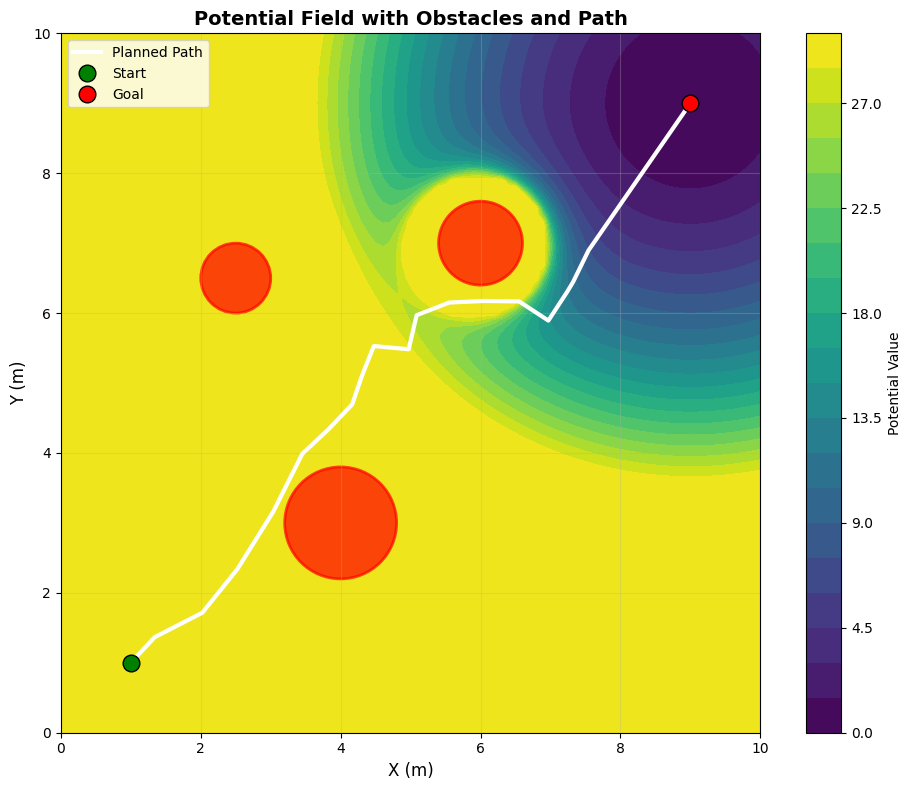


Step 9: Creating 3D Potential Surface


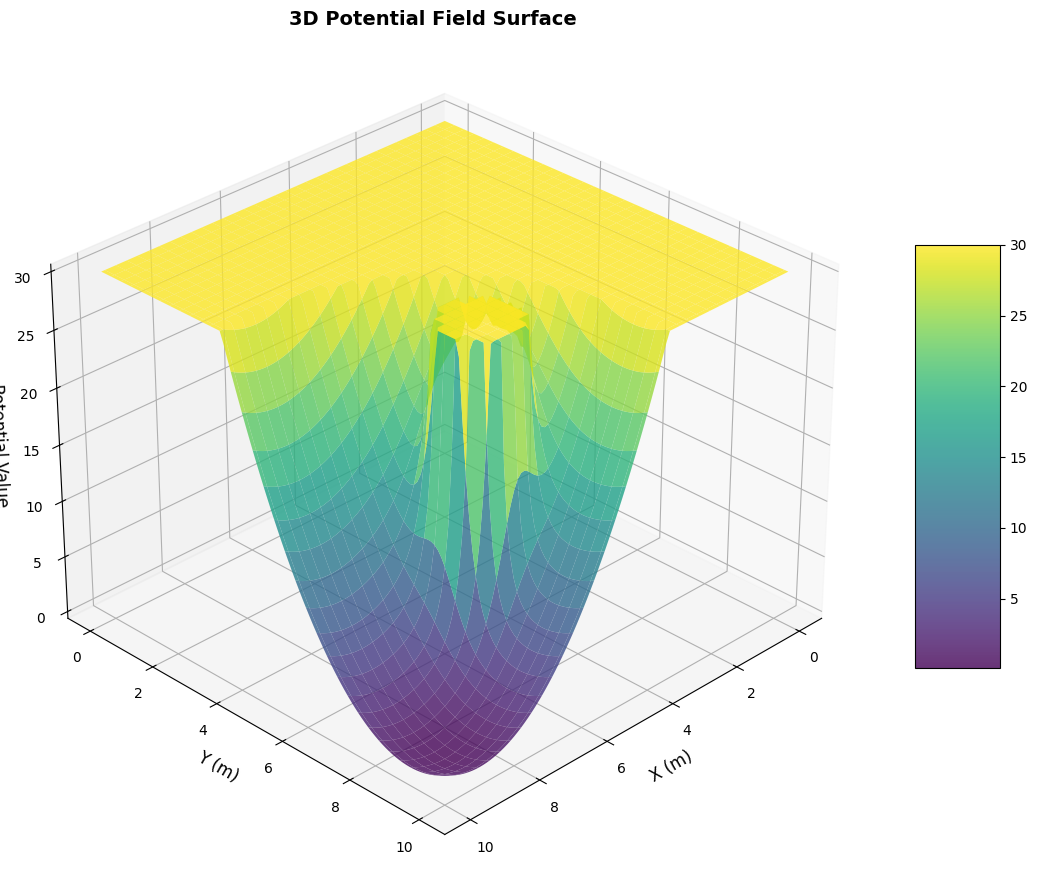


Step 10: Creating Gradient Field Plot


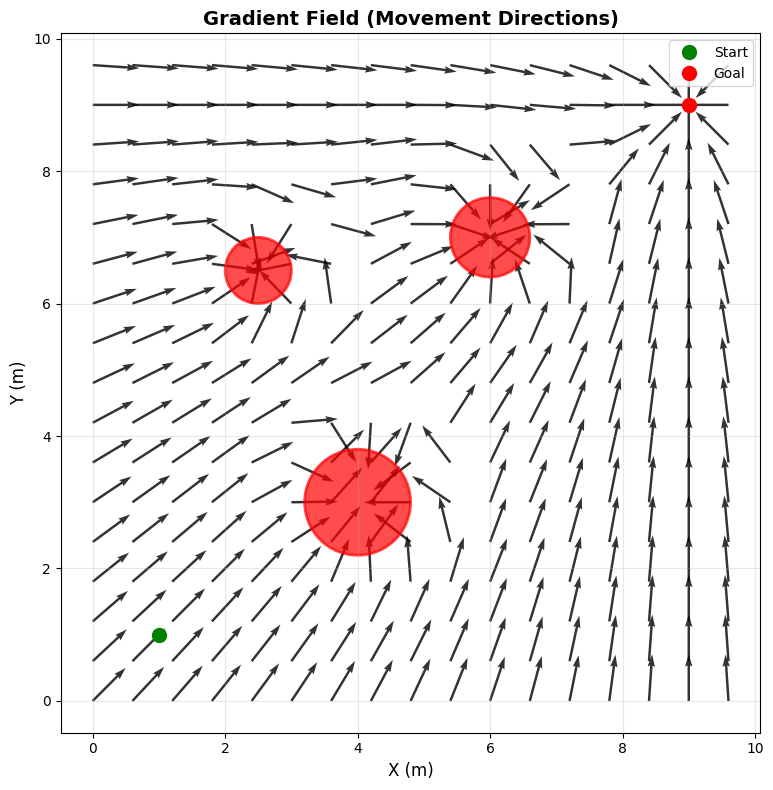


Step 11: Creating Final Path Plot


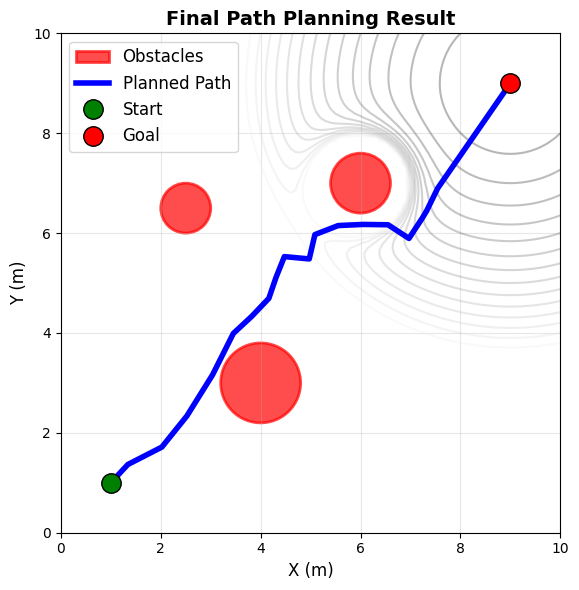


Step 12: Saving All Plots
Saving plots...
Individual plots saved:
- lab3_potential_field.png
- lab3_3d_potential.png
- lab3_gradient_field.png
- lab3_final_path.png

Step 13: Final Summary
Lab 3: Global Trajectory Planning using Potential Field Method
Algorithm Status: Successfully completed
Workspace: (10, 10)
Obstacles: 3 circular obstacles
Path points: 25
Path Efficiency: 90.0%
Status: COLLISION-FREE path successfully planned!


In [5]:
if __name__ == "__main__":
    show_all() 